In [16]:
import pandas as pd
import numpy as np
import sqlite3
from pprint import pprint
import folium
from folium import plugins
from folium.plugins import HeatMap
%matplotlib inline
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pygeohash as pgh
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from osgeo import gdal
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd
import requests
import urllib


# Organizing data

1. Conecting to sql database
2. creating a pandas df
3. Reducing the dataset:
    - Finding the number of wildfires in every state
    - Choosing one state for the case study


* One-time execution of that part,
 no need to run again after getting CSV file of the organized data

Conect to the database file

In [3]:
# notice that the sql file in the right dir
con = sqlite3.connect(r'data\FPA_FOD_20170508.sqlite')

In [5]:
# df = pd.read_sql_query("SELECT LATITUDE, LONGITUDE, FIRE_YEAR, CONT_DATE,DISCOVERY_DATE, CONT_TIME, FIRE_SIZE, STAT_CAUSE_DESCR FROM Fires;", con)
df = pd.read_sql_query('SELECT * FROM Fires;',con)
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


Fire's state

In [6]:
fire_state = df.pivot_table(index=['STATE'],aggfunc='size')

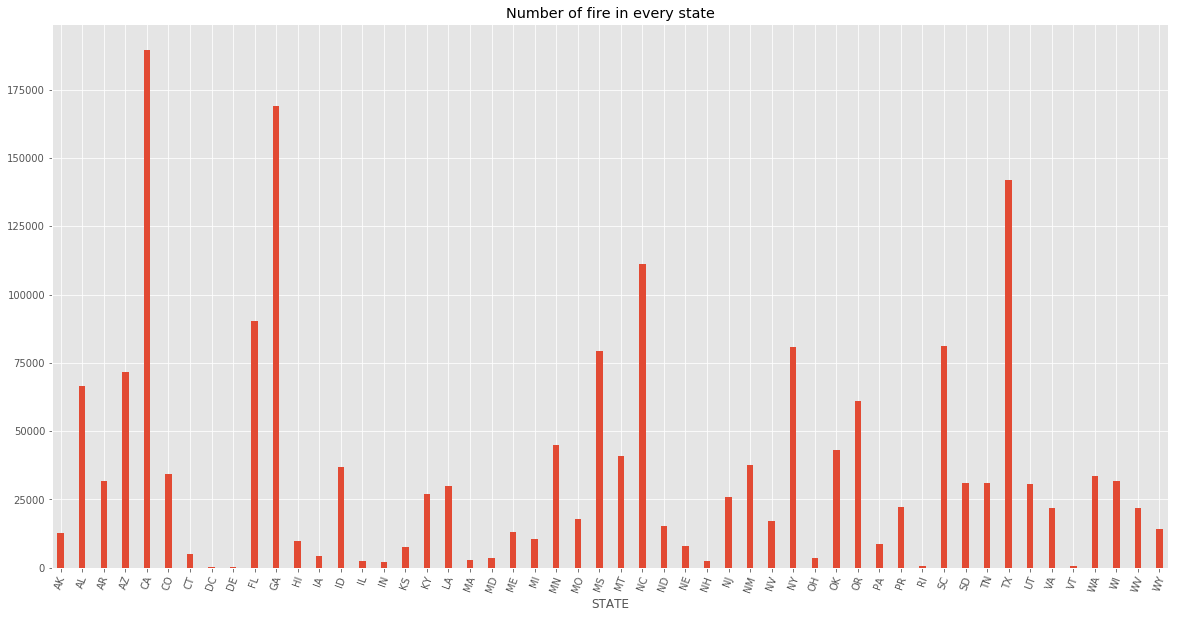

In [7]:
plt.figure(figsize=(20, 10))
fire_state.plot.bar(rot=70 ,align='center', width=0.3 ,title="Number of fire in every state")
plt.show()

Select the wildfires from California

For the case study we take only 25% randomly

In [9]:
CA_df = df.loc[df['STATE'] == 'CA']
CA_df_small = CA_df.sample(frac = 0.25)

In [12]:
CA_df_small.to_csv(r'data\California_fires.csv')


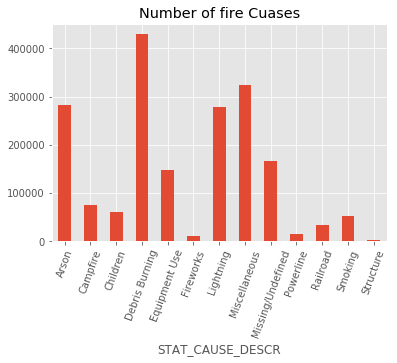

In [4]:
# Fire cuases
fireCuases = df.pivot_table(index=['STAT_CAUSE_DESCR'], aggfunc='size')
fireCuases.plot.bar(rot=70, title="Number of fire Cuases")
plt.show()

In [5]:
map_ = folium.Map(location=[df["LATITUDE"].mean(), df["LONGITUDE"].mean()],
                    tiles = "Stamen Terrain",
                    zoom_start = 3)


heat_df = df[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
# limit number of points, to get a processible result
heat_df = heat_df[heat_df["FIRE_SIZE"] > 1800]
heat_df = heat_df.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_data = [[row["LATITUDE"],row["LONGITUDE"]] for index, row in heat_df.iterrows()]
del heat_df

# Plot it on the map
HeatMap(heat_data, min_opacity=.4, max_val=.8).add_to(map_)

# Display the map
map_

In [6]:
# find the min/ max lon and lat for the bounding box
min_lat = df["LATITUDE"].min()
max_lat = df["LATITUDE"].max()
min_lon = df["LONGITUDE"].min()
max_lon = df["LONGITUDE"].max()
print(min_lat,'\n',min_lon,'\n', max_lat,'\n',max_lon)

17.93972222 
 -178.8026 
 70.3306 
 -65.25694444


# Case study California wildfires

In [4]:
# reading CSV
CA_fires = pd.read_csv('California_fires.csv')

### creating GeoDataFrame

In [7]:
locations = gpd.points_from_xy(x=CA_fires.LONGITUDE, y=CA_fires.LATITUDE)
CA_fires['geometry'] = locations
CA_fires.head()

In [ ]:
geo_fires = gpd.GeoDataFrame(CA_fires, geometry='geometry', crs="EPSG:4326")

California Heat map

In [15]:
map_CA = folium.Map(location=[geo_fires["LATITUDE"].mean(), geo_fires["LONGITUDE"].mean()],
                    tiles = "Stamen Terrain",
                    zoom_start = 3)


heat_df2 = geo_fires[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
# limit number of points, to get a processible result
# heat_df2 = heat_df2[heat_df2["FIRE_SIZE"] > 1800]
# heat_df2 = heat_df2.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_data2 = [[row["LATITUDE"],row["LONGITUDE"]] for index, row in heat_df2.iterrows()]
del heat_df2

# Plot it on the map
HeatMap(heat_data2, min_opacity=.4, max_val=.8).add_to(map_CA)

# Display the map
map_CA

In [ ]:
# USGS Elevation Point Query Service
url = r'https://nationalmap.gov/epqs/pqs.php?'

def elevation_function(df, lat_column, lon_column):
    """
    Query service using lat, lon. add the elevation values as a new column
    :param df: DataFrame
    :param lat_column:
    :param lon_column:
    :return:
    """
    elevations = []
    for lat, lon in zip(df[lat_column], df[lon_column]):

        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }

        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])

    df['elev_meters'] = elevations

elevation_function(geo_fires, 'LATITUDE', 'LONGITUDE')
df.head()